## iPyLeaflet
[ipyleaflet](https://github.com/ellisonbg/ipyleaflet) is a bridge between jupyter notebooks and the [leaflet](http://leafletjs.com/)  javascript library for drawing maps.

ipyleaflet comes with a few examples notebooks (this notebook was derived from one) but very little documentation,
for more documentation read the [Leaflet IPA](http://leafletjs.com/reference.html)

For installation directions, see the README on [ipyleaflet](https://github.com/ellisonbg/ipyleaflet)

In [1]:
from ipyleaflet import (
    Map,
    Marker,
    TileLayer, ImageOverlay,
    Polyline, Polygon, Rectangle, Circle, CircleMarker,
    GeoJSON,
    DrawControl
)

## Visualizing the distribution of the observations

## Load the required libraries

In [2]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math

In [3]:
import findspark
findspark.init()

from pyspark import SparkContext
#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

In [4]:
import sys
sys.path.append('./lib')

import numpy as np
from numpy_pack import packArray,unpackArray
from spark_PCA import computeCov
from computeStats import computeOverAllDist, STAT_Descriptions

In [5]:
### Read the data frame from pickle file

data_dir='../../Data/Weather'
file_index='BBBBSSBB'
meas='SNWD'

from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
print('keys from STAT=',STAT.keys())

#!ls -ld $data_dir/*.parquet

#read data
filename=data_dir+'/decon_%s_%s.parquet'%(file_index,meas)

df=sqlContext.read.parquet(filename)
print(df.count())
df.show(2)

('keys from STAT=', ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP'])
1458
+-----------------+------------------+------------------+------------------+---------+--------+--------+---------+-----------+-------------------+-------------------+-------------------+--------------------+------------------+-----------+--------------------+------+--------------------+------+
|          coeff_1|           coeff_2|           coeff_3|           coeff_4|elevation|   label|latitude|longitude|measurement|              res_1|              res_2|              res_3|               res_4|          res_mean|    station|           total_var|undefs|              vector|  year|
+-----------------+------------------+------------------+------------------+---------+--------+--------+---------+-----------+-------------------+-------------------+-------------------+--------------------+------------------+-----------+--------------------+------+--------------------+------+
|9171.110131269304| 2087.753769407183|  

In [6]:
#extract longitude and latitude for each station
feature='coeff_1'
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT station, latitude,longitude,elevation,%s FROM weather"%feature
print(Query)
df1 = sqlContext.sql(Query)
df1.show(4)

SELECT station, latitude,longitude,elevation,coeff_1 FROM weather
+-----------+--------+---------+---------+-----------------+
|    station|latitude|longitude|elevation|          coeff_1|
+-----------+--------+---------+---------+-----------------+
|USC00306184| 43.7025| -74.9839|    532.8|9171.110131269304|
|USC00300785| 43.4361| -75.3697|    472.4|6367.604742371777|
|USC00304912| 43.7975| -75.4817|    262.1|4894.513795875696|
|USC00308248|    43.9| -75.0367|    515.1|7370.677472384773|
+-----------+--------+---------+---------+-----------------+
only showing top 4 rows



In [7]:
df1a=df1.groupby(['station','latitude','longitude','elevation']).agg({"station": "count", feature: "mean"})
pdf1=df1a.toPandas()
pdf1.sort_values(by=['station'],inplace=True)
pdf1.head(2)

,station,latitude,longitude,elevation,count(station),avg(coeff_1)
54,CA006150815,43.9800,-77.2200,91.0,1,-29.184093
26,US1NYOD0014,43.1658,-75.2451,276.1,1,2444.072522


In [8]:
#extract year
feature2='coeff_4'
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT year,latitude,longitude,elevation,%s FROM weather"%feature2
print(Query)
df2 = sqlContext.sql(Query)
df2.show(4)

SELECT year,latitude,longitude,elevation,coeff_4 FROM weather
+------+--------+---------+---------+------------------+
|  year|latitude|longitude|elevation|           coeff_4|
+------+--------+---------+---------+------------------+
|1977.0| 43.7025| -74.9839|    532.8|480.25180925690347|
|1952.0| 43.4361| -75.3697|    472.4|-180.2536726437042|
|1994.0| 43.7975| -75.4817|    262.1| 466.5516240861696|
|1978.0|    43.9| -75.0367|    515.1| 810.1031211372076|
+------+--------+---------+---------+------------------+
only showing top 4 rows



In [9]:
df2a=df2.groupby(['year','latitude','longitude','elevation']).agg({"year": "count", feature2: "mean"})
pdf2=df2a.toPandas()
pdf2.sort_values(by=['year'],inplace=True)
pdf2.head(2)

,year,latitude,longitude,elevation,count(year),avg(coeff_4)
1260,1900.0,43.4333,-73.7167,106.7,1,57.111750
1338,1901.0,43.4333,-73.7167,106.7,1,-221.839294


In [10]:
llminmax = ('order by latitude', 'order by latitude desc', 'order by longitude', 'order by longitude desc')
for ll in llminmax:
    Query="SELECT station, latitude,longitude,elevation FROM weather {0}".format(ll)
    dfll = sqlContext.sql(Query)
    print dfll.show(2)

+-----------+--------+---------+---------+
|    station|latitude|longitude|elevation|
+-----------+--------+---------+---------+
|USW00014771| 43.1111| -76.1039|    125.9|
|USW00014771| 43.1111| -76.1039|    125.9|
+-----------+--------+---------+---------+
only showing top 2 rows

None
+-----------+--------+---------+---------+
|    station|latitude|longitude|elevation|
+-----------+--------+---------+---------+
|CA006150815|   43.98|   -77.22|     91.0|
|USC00309000| 43.9761| -75.8753|    151.5|
+-----------+--------+---------+---------+
only showing top 2 rows

None
+-----------+--------+---------+---------+
|    station|latitude|longitude|elevation|
+-----------+--------+---------+---------+
|CA006150815|   43.98|   -77.22|     91.0|
|USC00307842| 43.2078| -77.0128|    128.0|
+-----------+--------+---------+---------+
only showing top 2 rows

None
+-----------+--------+---------+---------+
|    station|latitude|longitude|elevation|
+-----------+--------+---------+---------+
|USC003

In [11]:
#define a mapping from the range of the value to hex colors.
from matplotlib.colors import rgb2hex
_avg='avg(%s)'%feature
_min=pdf1[_avg].min()
_max=pdf1[_avg].max()
_min,_max

import pylab as plt
cmap=plt.get_cmap('jet')
def get_color(val):
    x=(val-_min)/(_max-_min)
    return(rgb2hex(cmap(x)[:3]))

get_color(1000.)

u'#0014ff'

## Map

In [12]:
# get the longitude and the latitude of our area of study
min_lat = None
min_long = None
max_lat = None
max_long = None

for index,row in pdf1.iterrows():
    _lat=row['latitude']
    _long=row['longitude']
    
    if _lat < min_lat or min_lat is None:
        min_lat = _lat
        
    if _long < min_long or min_long is None:
        min_long = _long
        
    if _lat > max_lat or max_lat is None:
        max_lat = _lat

    if _long > max_long or max_long is None:
        max_long = _long

In [13]:
!jupyter nbextension enable --py widgetsnbextension


center = [(min_lat+max_lat)/2, (min_long+max_long)/2]
zoom = 8

m = Map(default_tiles=TileLayer(opacity=1.0), center=center, zoom=zoom)

r = Rectangle(bounds=[[min_lat,min_long],[max_lat,max_long]], weight=5, fill_opacity=0.0)
m += r

circles = []
for index,row in pdf1.iterrows():
    _lat=row['latitude']
    _long=row['longitude']
    _count=row['count(station)']
    _coef=row[_avg]
    # taking sqrt of count so that the  area of the circle corresponds to the count
    c = Circle(location=(_lat,_long), radius=int(400*np.sqrt(_count+0.0)), weight=1,
            color='#F00', opacity=0.8, fill_opacity=0.4,
            fill_color=get_color(_coef))
    circles.append(c)
    m.add_layer(c)
m

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


### excercises:
* Add a legend that relates the colors to values.
* Leaflet supports a variety of maps. See if you can get a topographical map as the background.

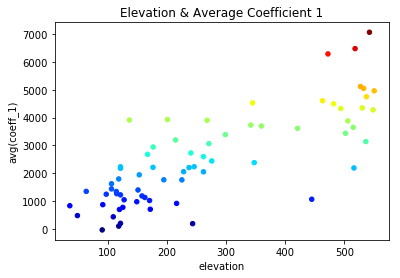

In [14]:
%matplotlib inline

colors = []

for index,row in pdf1.iterrows():
    _coef=row[_avg]
    colors.append(get_color(_coef))

pdf1.plot.scatter(x='elevation',y='avg(coeff_1)', c=colors, title='Elevation & Average Coefficient 1');

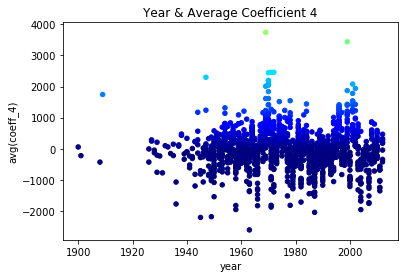

In [15]:
colors = []

for index,row in pdf2.iterrows():
    _coef=row['avg(coeff_4)']
    colors.append(get_color(_coef))

pdf2.plot.scatter(x='year',y='avg(coeff_4)', c=colors, title='Year & Average Coefficient 4');

In [16]:
m = Map(default_tiles=TileLayer(opacity=1.0), center=center, zoom=zoom)

r = Rectangle(bounds=[[min_lat,min_long],[max_lat,max_long]], weight=5, fill_opacity=0.0)
m += r

circles = []

for index,row in pdf1.iterrows():
    _lat=row['latitude']
    _long=row['longitude']
    _height=row['elevation']
    _coef=row[_avg]
    # taking sqrt of count so that the area of the circle corresponds to the count
    c = Circle(location=(_lat,_long), radius=int(300*np.sqrt(_height)), weight=1,
            color='#F00', opacity=0.8, fill_opacity=0.4,
            fill_color=get_color(_coef))
    circles.append(c)
    m.add_layer(c)

m

In [17]:
pdf3=df1.toPandas()
pdf3.sort_values(by=['station'],inplace=True)
pdf3.head(2)

,station,latitude,longitude,elevation,coeff_1
1406,CA006150815,43.9800,-77.2200,91.0,-29.184093
470,US1NYOD0014,43.1658,-75.2451,276.1,2444.072522


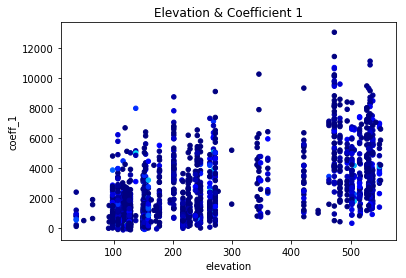

In [18]:
for index,row in pdf3.iterrows():
    _coef=row['coeff_1']
    colors.append(get_color(_coef))

pdf3.plot.scatter(x='elevation',y='coeff_1', c=colors, title='Elevation & Coefficient 1');